In [174]:
from input_feeder import InputFeeder
from face_detection import FaceDetection
from emotions_recognition import EmotionsRecognition
from face_reidentification import FaceReidentification

import time
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
%matplotlib inline

In [161]:
parent_dir =  os.path.split(os.getcwd())[0]

input_video = os.path.join(parent_dir,'input_video','netflix.mp4')

input_feeder = InputFeeder('video',input_video)
input_feeder.load_data()

face_detection= FaceDetection()
face_detection.load_model()

emotions_recognition = EmotionsRecognition()
emotions_recognition.load_model()

face_reidentification = FaceReidentification()
face_reidentification.load_model()

In [162]:
emotions = {0:'neutral',1:'happy',2:'sadness',3:'surprise',4:'anger'}
faces_db = {}
emotions_db = {}
face_vectors_db = []

In [163]:
def update_(face,face_emotion,face_vector):
    
    similarity = [0]
    for face_vector_cmp in face_vectors_db:
        similarity.append(cosine_similarity(face_vector,face_vector_cmp))
    
    if max(similarity)>0.5:
        faces_db[np.argmax(similarity)-1].append(face)
        emotions_db[np.argmax(similarity)-1].append(face_emotion)
        
    else:
        face_vectors_db.append(face_vector)
        faces_db[len(faces_db)] = [face]
        emotions_db[len(emotions_db)] = [face_emotion]

In [164]:
def show_faces_db():
    print(f"The number face detected are: {len(faces_db)}")
    plt.figure(figsize=(20,10))
    for index,face in faces_db.items():
        img = cv2.resize(face[0], (50,50))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.subplot(1,len(faces_db),index+1)
        plt.imshow(img,interpolation='bilinear')
        plt.title(f"FACE_{index}")
        plt.axis(False)
    plt.show()

In [165]:
def add_emotion_emoji(face_emotion,cord,bbox_frame):
    l = cord[0]
    m = cord[0]+20
    n = cord[1]+cord[3]-20
    o = cord[1]+cord[3]
    bbox_frame[n:o,l:m,:] = cv2.resize(cv2.imread(os.path.join(parent_dir,'bin',f'{emotions[face_emotion]}.png')),(20,20))

In [166]:
def plot_emotion_count(bbox_frame,emotions_count):
    fig = Figure()
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.axis('off')
    ax.set_ylim(0,len(emotions_count))
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    ax.bar(emotions.values(),emotions_count,color='red')
    canvas.draw()
    w, h = (fig.get_size_inches() * fig.get_dpi()).astype(int)
    x = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(h,w,3)
    x = cv2.resize(x, (216,144))
    bbox_frame[276:420,504:720,2] = np.where(x[:,:,2]==0,255,frame[276:420,504:720,2])
    bbox_frame[420:450,534:564,:] = cv2.resize(cv2.imread(os.path.join(parent_dir,'bin','neutral.png')),(30,30))
    bbox_frame[420:450,568:598,:] = cv2.resize(cv2.imread(os.path.join(parent_dir,'bin','happy.png')),(30,30))
    bbox_frame[420:450,602:632,:] = cv2.resize(cv2.imread(os.path.join(parent_dir,'bin','sadness.png')),(30,30))
    bbox_frame[420:450,636:666,:] = cv2.resize(cv2.imread(os.path.join(parent_dir,'bin','surprise.png')),(30,30))
    bbox_frame[420:450,670:700,:] = cv2.resize(cv2.imread(os.path.join(parent_dir,'bin','anger.png')),(30,30))

In [167]:
output_video = os.path.join(parent_dir,'output_video','netflix.mp4')
out = cv2.VideoWriter(output_video, 0x00000021, 18, (720,480))

In [168]:
for frame in input_feeder.next_batch():
    if frame is None:
        break
    emotions_count = [0,0,0,0,0]
    bbox_frame,faces,cords = face_detection.predict(frame)
    for index,face in enumerate(faces):
        face_emotion = emotions_recognition.predict(face)
        face_vector  = face_reidentification.predict(face)
        add_emotion_emoji(face_emotion,cords[index],bbox_frame)
        update_(face,face_emotion,face_vector)
        emotions_count[face_emotion] += 1
    plot_emotion_count(bbox_frame,emotions_count)
    out.write(bbox_frame)

out.release()
input_feeder.close()

In [169]:
%%HTML
<video width="720" height="480" controls>
  <source src="../output_video/netflix.mp4" type="video/mp4">
</video>

In [273]:
def report(faces_db,emotions_db,treshold=15):
    k = 0
    for index in list(faces_db):
        if len(faces_db[index])>= treshold:
            k = 10
            plt.figure(figsize=(10,50))
            plt.subplot(k,4,1)
            img = cv2.resize(faces_db[index][0], (50,50))
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            plt.imshow(img,interpolation='bilinear')
            plt.title(f"FACE_{index}")
            plt.axis(False)
            plt.subplot(k,4,2) 
            plt.pie(pd.value_counts(emotions_db[index]).values,labels=[emotions[i] for i in pd.value_counts(emotions_db[index]).index],autopct='%1.1f%%',
                   shadow=True, startangle=90)
            plt.subplot(k,4,3) 
            plt.plot(emotions_db[index],'r--')
            plt.yticks(pd.value_counts(emotions_db[index]).index,[emotions[i] for i in pd.value_counts(emotions_db[index]).index])
            plt.xlabel("FRAMES")
            plt.subplot(k,4,4)
            plt.hist(emotions_db[index])
            plt.xticks(pd.value_counts(emotions_db[index]).index,[emotions[i] for i in pd.value_counts(emotions_db[index]).index])
            plt.ylabel("FRAME COUNT",labelpad=0)
    plt.show()

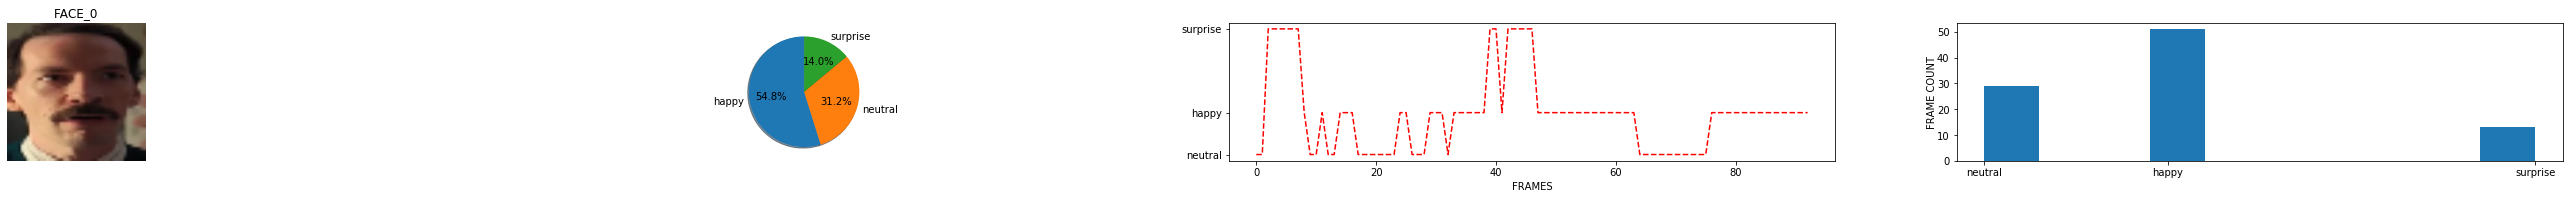

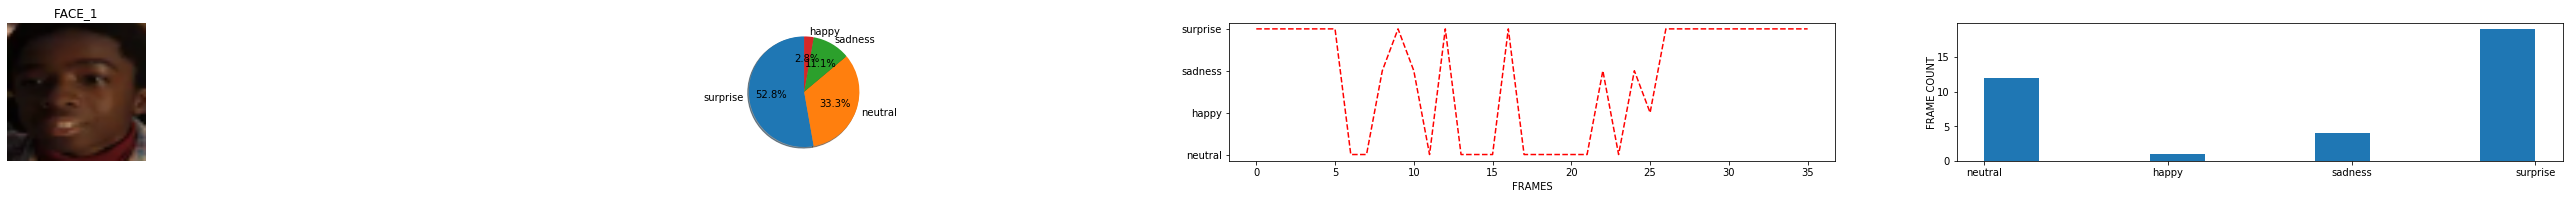

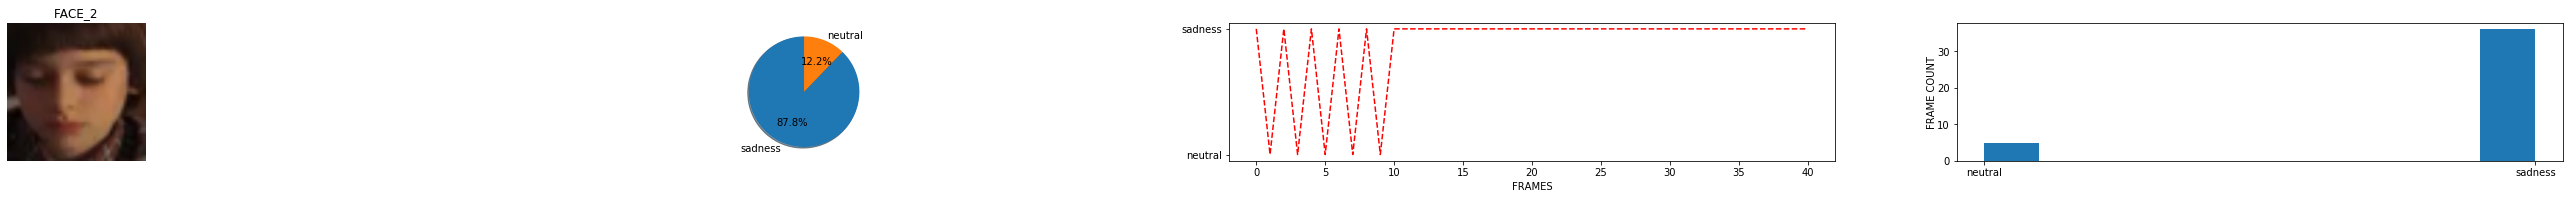

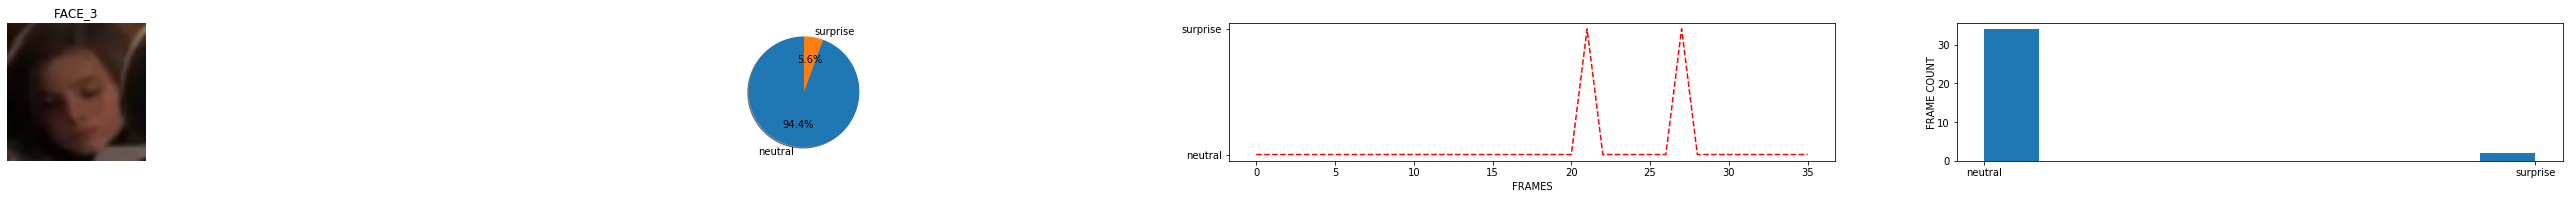

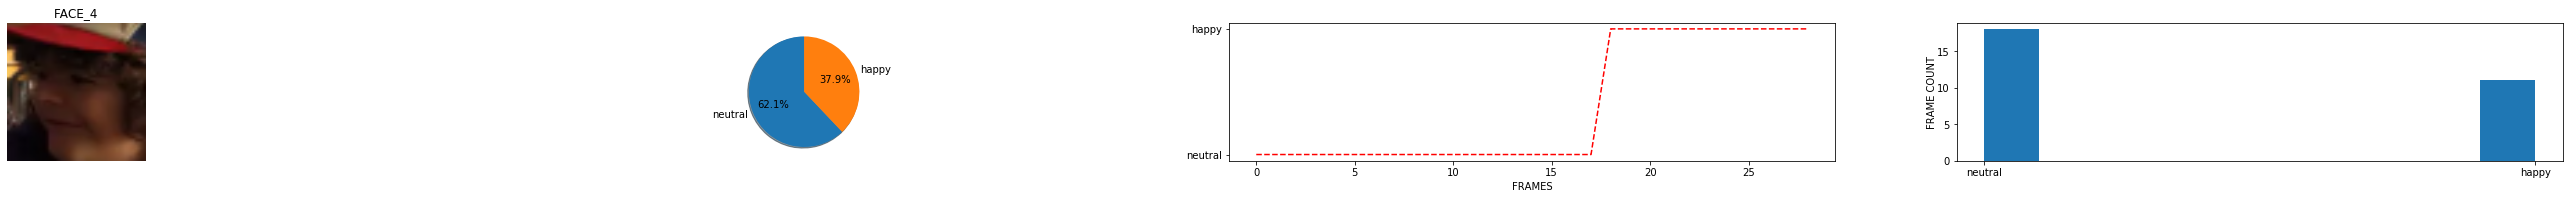

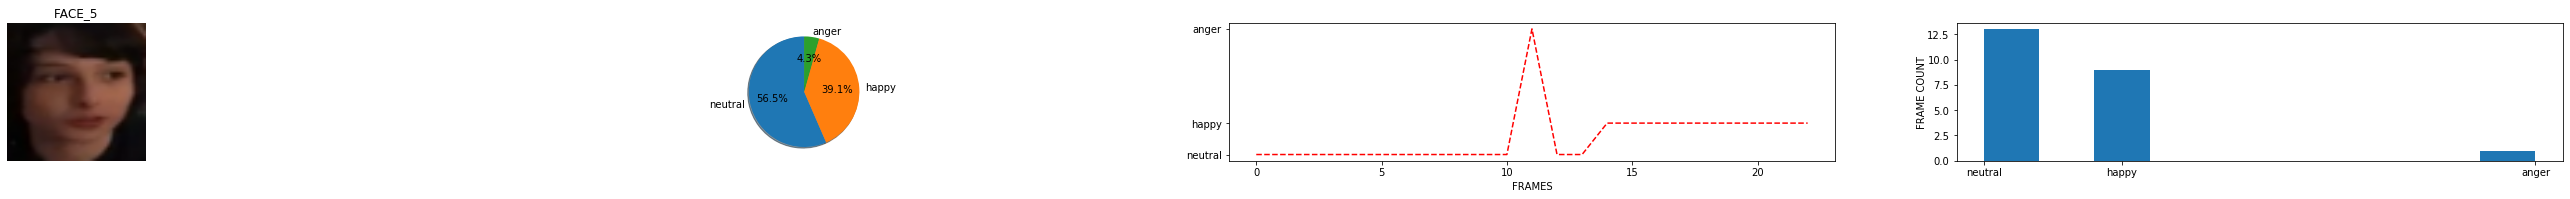

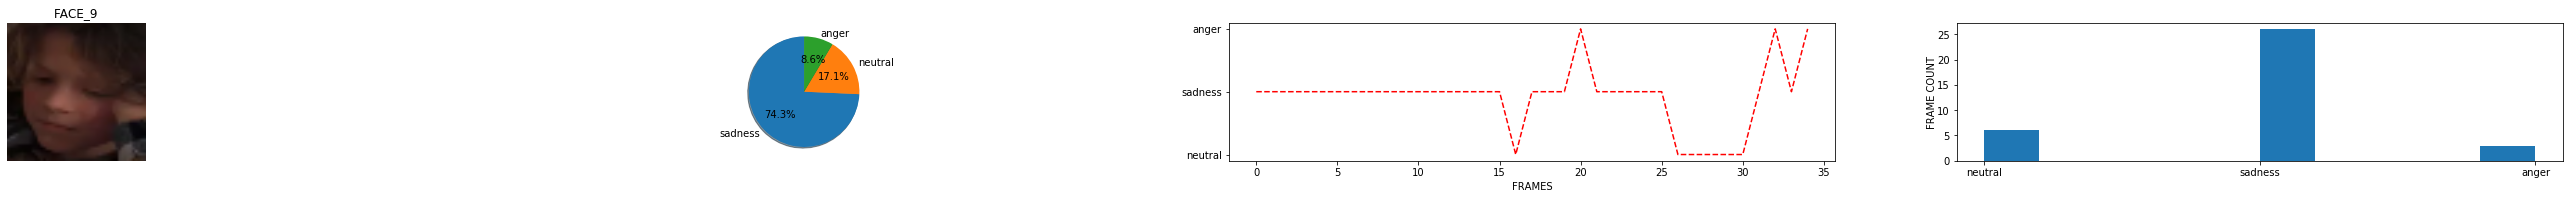

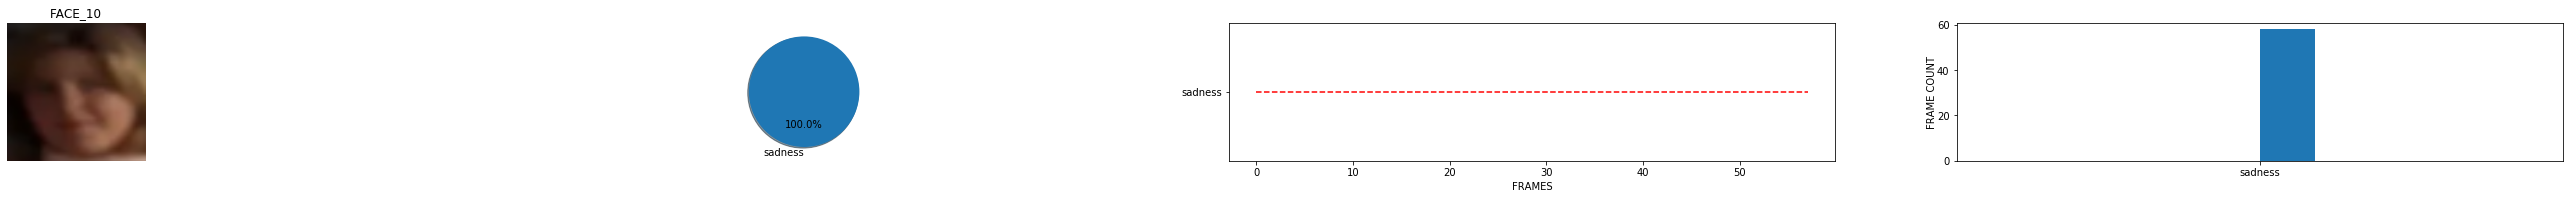

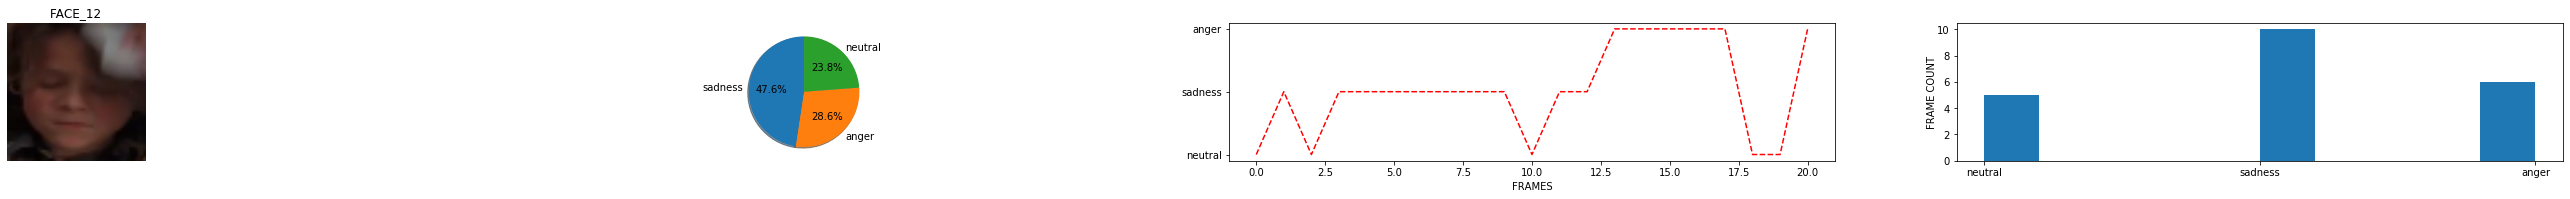

In [ ]:
report(faces_db,emotions_db)